In [ ]:
import sqlite3
from sqlite3 import Connection

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def build_response_relations(conn: Connection, response_type: str):
    cur = conn.cursor()
    query = """
            SELECT
                t1.author_id as source_author,
                t2.author_id as dest_author
            FROM tweets t1
            JOIN referenced_tweets rt ON t1.id = rt.tweet_id
            JOIN tweets t2 ON rt.referenced_tweet_id = t2.id
            WHERE
                rt.referenced_tweet_type = ?
                AND t1.author_id != t2.author_id
            """
    result = cur.execute(query, [response_type]).fetchall()
    return result

In [3]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
retweet_edges = build_response_relations(conn, "retweeted")
print(len(retweet_edges))

1385201


In [4]:
reply_edges = build_response_relations(conn, "replied_to")
print(len(reply_edges))

38290


In [5]:
def get_distinct_authors(conn: Connection):
    cur = conn.cursor()
    result = cur.execute("SELECT DISTINCT author_id FROM tweets")
    return result.fetchall()

In [6]:
authors = get_distinct_authors(conn)
authors_list = [''.join(author) for author in authors]
# print(authors[:10])
# print(authors_list[:10])
print(len(authors_list))
conn.close()

481467


In [7]:
print(retweet_edges[:3])
print(authors_list[:3])

[('1011975294', '1471250628'), ('255144027', '313743136'), ('214748274', '4010449719')]
['1011975294', '255144027', '214748274']


In [8]:
retweet_graph = ig.Graph(n=len(authors_list))
retweet_graph["title"] = "Retweet network"
retweet_graph.vs["name"] = authors_list
retweet_graph.add_edges(retweet_edges)
retweet_graph.simplify()
retweet_graph.summary()

'IGRAPH UN-- 481467 1225822 -- \n+ attr: title (g), name (v)'

In [9]:
# fig, ax = plt.subplots(figsize=(10, 10))
# layout = retweet_graph.layout("circle")
# visual_style = {
#     "vertex_size": 20,
#     "vertex_label": retweet_graph.vs["name"],  # Show vertex names
#     "vertex_color": "red",
#     "edge_color": "black",
#     "bbox": (300, 300),  # Width and height of the plot
#     "margin": 20,  # Margin around the graph
# }

# ig.plot(retweet_graph, target=ax, layout=layout, **visual_style)

In [10]:
reply_graph = ig.Graph(n=len(authors_list))
reply_graph["title"] = "Reply network"
reply_graph.vs["name"] = authors_list
reply_graph.add_edges(reply_edges)
reply_graph.simplify()
reply_graph.summary()

'IGRAPH UN-- 481467 31250 -- \n+ attr: title (g), name (v)'

In [11]:
# fig, ax = plt.subplots(figsize=(10, 10))
# layout = reply_graph.layout("circle")
# visual_style = {
#     "vertex_size": 5,
#     "vertex_label": reply_graph.vs["name"],  # Show vertex names
#     "vertex_color": "red",
#     "edge_color": "black",
#     "bbox": (300, 300),  # Width and height of the plot
#     "margin": 20,  # Margin around the graph
# }

# ig.plot(reply_graph, target=ax, layout=layout, **visual_style)
# plt.show()

In [12]:
def analyze_graph(g: ig.Graph):
    order = g.vcount()
    size = g.ecount()
    components = g.components()
    no_components = len(components)
    size_of_largest_component = max([len(component) for component in components])
    density = g.density()
    transitivity = g.transitivity_avglocal_undirected()
    
    print(f"Order: {order}")
    print(f"Size: {size}")
    print(f"No .of Components: {no_components}")
    print(f"Size of largest component: {size_of_largest_component}")
    print(f"Density: {density}")
    print(f"Transitivity: {transitivity}")
    
    degree_dist = g.degree()
    degree_counts = np.bincount(degree_dist)
    degrees = np.arange(len(degree_counts))
    
    non_zero = degree_counts > 0
    degrees = degrees[non_zero]
    degree_counts = degree_counts[non_zero]
    
    plt.figure(figsize=(8, 6))
    plt.loglog(degrees, degree_counts, marker="o", linestyle="", markersize=6, alpha=0.7, label="Degree Distribution")
    plt.title("Degree Distribution (Log-Log Scale)")
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.grid(which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()
    
    # return {
    #     "order": order,
    #     "size": size,
    #     "components": len(g.components()),
    #     "density": density,
    #     "clustering_coefficient": transitivity
    # }

Analyzing retweet graph:
Order: 481467
Size: 1225822
No .of Components: 152103
Size of largest component: 328823
Density: 1.0576092917400455e-05
Transitivity: 0.15526670774627926


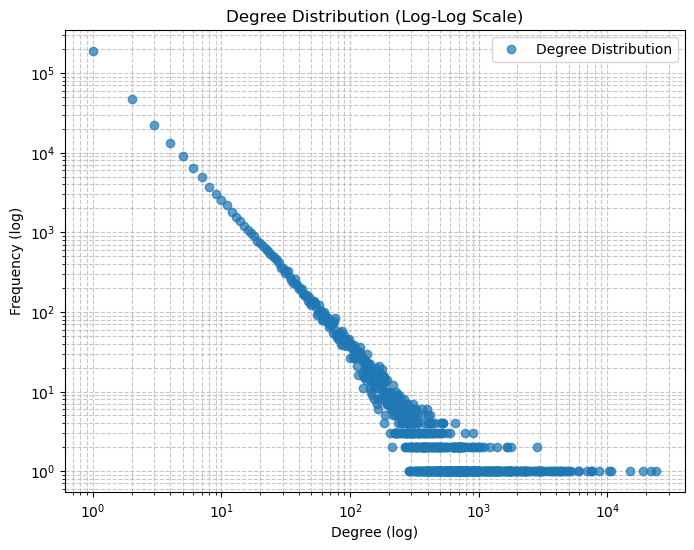

In [13]:
print("Analyzing retweet graph:")
analyze_graph(retweet_graph)

Analyzing reply graph:
Order: 481467
Size: 31250
No .of Components: 454492
Size of largest component: 24553
Density: 2.6961736995156246e-07
Transitivity: 0.20696751622455148


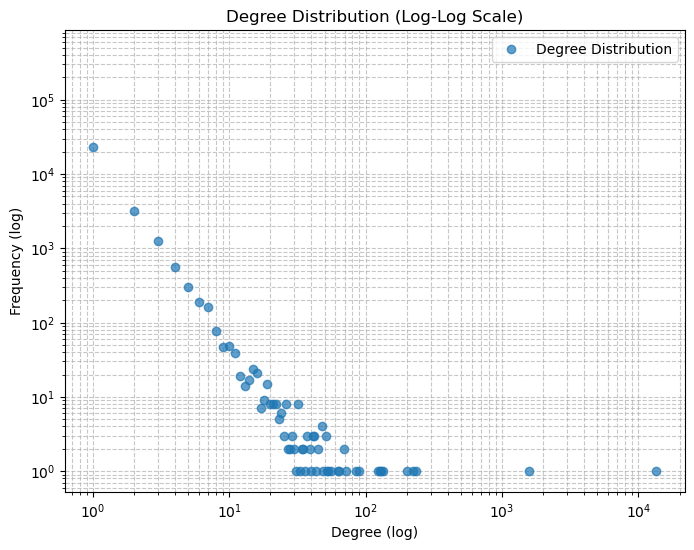

In [14]:
print("Analyzing reply graph:")
analyze_graph(reply_graph)

In [15]:
def prepare_graph(g: ig.Graph):
    layout = g.layout("fr") # circle
    
    g.vs["color"] = "red"
    g.vs["size"] = 1
    g.vs["frame_width"] = 0
    g.vs["label"] = None
    
    g.es["color"] = "rgba(0, 0, 0, 0.1)"
    g.es["width"] = 0.5
    
    return g, layout

In [16]:
def plot_graph(g: ig.Graph, layout: ig.Layout, target_file = None):
    visual_style = {
        "layout": layout,
        "vertex_color": g.vs["color"],
        "vertex_size": g.vs["size"],
        "vertex_frame_width": 0,
        "vertex_label": None,
        "edge_color": g.es["color"],
        "edge_width": g.es["width"],
        # "bbox": (800, 800),  # Image size in pixels
        "margin": 2,
    }

    # Use matplotlib as the engine for visualization
    plt.figure(figsize=(10, 10))
    ig_plot = ig.plot(g, target=target_file, **visual_style, backend="matplotlib")

    if target_file is None:
        plt.show()  # Show plot interactively
    else:
        print(f"Plot saved to: {target_file}")

In [17]:
reply_graph, layout = prepare_graph(reply_graph)

Plot saved to: reply_graph.png


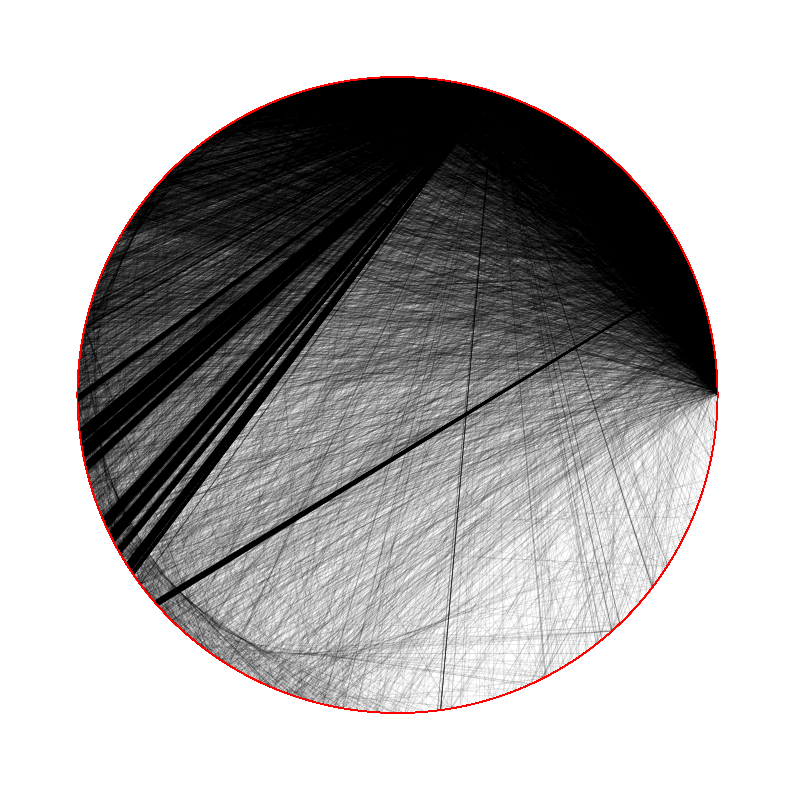

In [31]:
plot_graph(reply_graph, layout, "reply_graph.png")

In [71]:
def prepare_graph_for_degree(g: ig.Graph, base_size = 1, scale_factor = 10):
    degrees = g.degree()
    max_degree = max(degrees)
    
    g.vs["size"] = [base_size + scale_factor * (degree/max_degree) for degree in degrees]
    
    return g

In [72]:
reply_graph_degrees = prepare_graph_for_degree(reply_graph)

Plot saved to: reply_graph_degrees.png


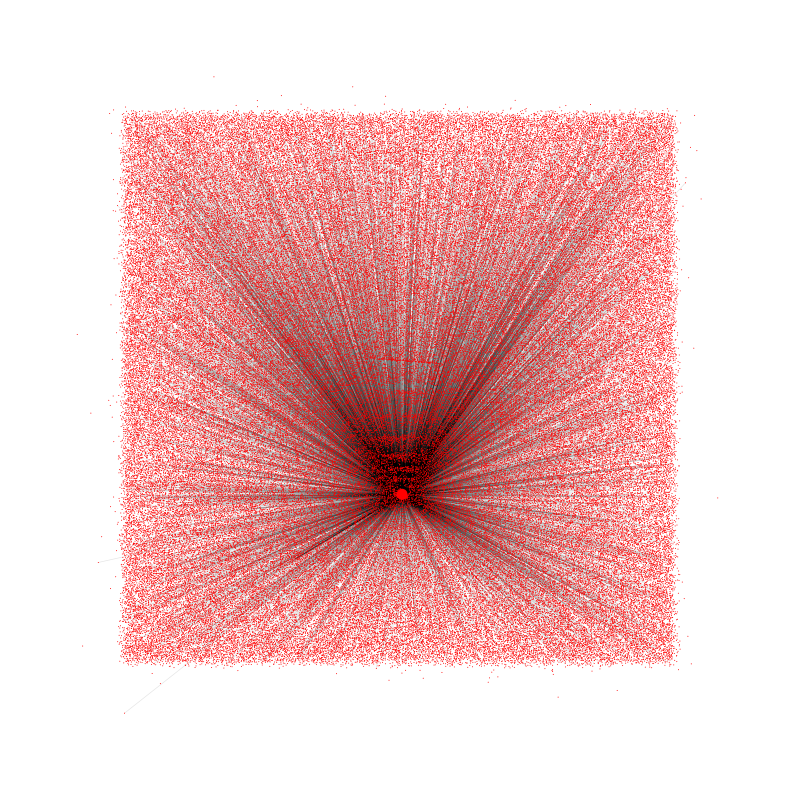

In [73]:
plot_graph(reply_graph_degrees, layout, "reply_graph_degrees.png")

In [68]:
def prepare_graph_for_betweenness(g: ig.Graph, base_size = 1, scale_factor = 10):
    betweenness = g.betweenness()
    max_betweenness = max(betweenness) if max(betweenness) > 0 else 1
    
    g.vs["size"] = [base_size + scale_factor * (b/max_betweenness) for b in betweenness]
    
    return g

In [69]:
reply_graph_betweenness = prepare_graph_for_betweenness(reply_graph)

Plot saved to: reply_graph_betweenness.png


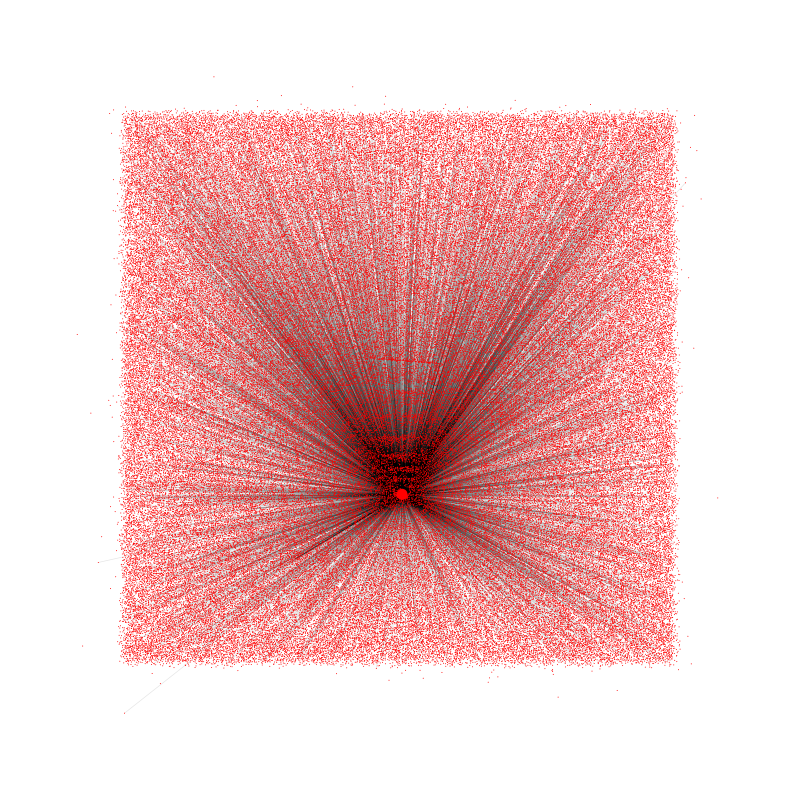

In [70]:
plot_graph(reply_graph_betweenness, layout, "reply_graph_betweenness.png")

### Betweenness for Retweet network

In [18]:
def prepare_retweet_for_betweenness(g: ig.Graph, base_size = 1, scale_factor = 10):
    g_betweenness = g.components().giant()
    betweenness = g_betweenness.betweenness(cutoff=30)
    max_betweenness = max(betweenness) if max(betweenness) > 0 else 1
    
    g_betweenness.vs["size"] = [base_size + scale_factor * (b/max_betweenness) for b in betweenness]
    
    return g_betweenness, betweenness

# TO BE RUN TONIGHT

In [73]:
retweet_graph_betweenness, retweet_betweenness_values = prepare_retweet_for_betweenness(retweet_graph)

In [85]:
retweet_graph_betweenness.vs["color"] = "red"
retweet_graph_betweenness.vs["frame_width"] = 0
retweet_graph_betweenness.vs["label"] = None

retweet_graph_betweenness.es["color"] = "rgba(0, 0, 0, 0.1)"
retweet_graph_betweenness.es["width"] = 0.5

Plot saved to: retweet_graph_betweenness.png


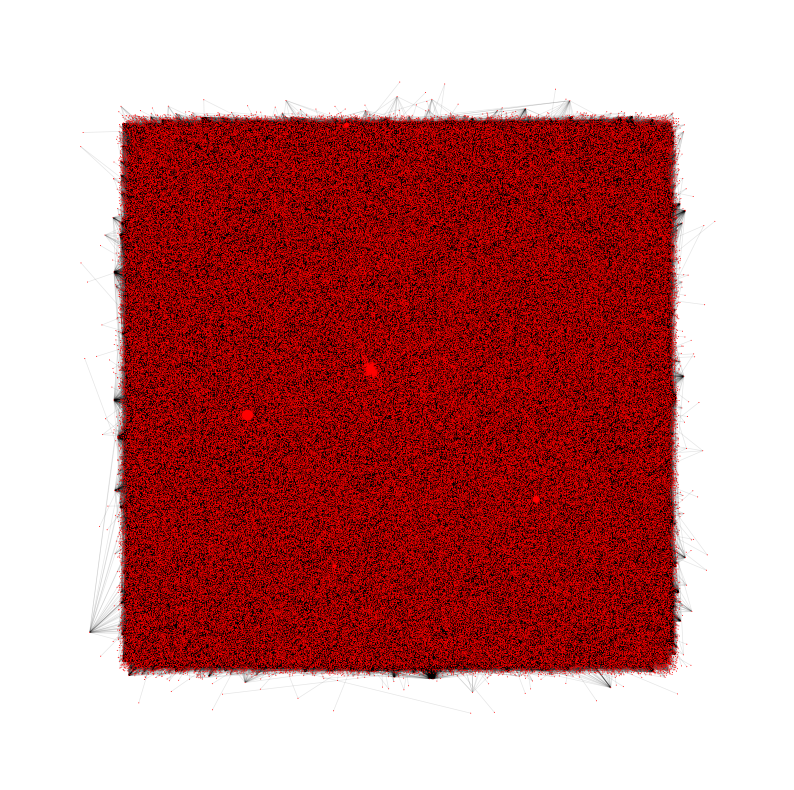

In [86]:
plot_graph(retweet_graph_betweenness, layout, "retweet_graph_betweenness.png")

# ABOVE CELL

In [19]:
def top_10_for_network(g: ig.Graph):
    degrees = g.degree()
    degree_dict = {g.vs[i]["name"]: degrees[i] for i in range(len(g.vs))}

    top_10_degrees = dict(sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)[:10])

    betweenness = g.betweenness()
    betweenness_dict = {g.vs[i]["name"]: betweenness[i] for i in range(len(g.vs))}
    top_10_betweenness = dict(sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)[:10])

    return top_10_degrees, top_10_betweenness

In [20]:
top_10_degrees_reply, top_10_betweenness_reply = top_10_for_network(reply_graph)
print("Top 10 authors for degree in reply graph:")
print(top_10_degrees_reply)
print("Top 10 authors for betweenness in reply graph:")
print(top_10_betweenness_reply)

Top 10 authors for degree in reply graph:
{'4339043357': 13546, '2617471956': 1568, '17463923': 233, '368980703': 224, '244013273': 200, '14159148': 135, '330826792': 130, '69032746': 127, '3584633117': 124, '3382476081': 89}
Top 10 authors for betweenness in reply graph:
{'4339043357': 290009484.18830454, '2617471956': 32789037.0150213, '17463923': 4608728.853726735, '368980703': 4101396.2654589606, '244013273': 3858604.706226033, '3584633117': 2740073.6861052113, '14159148': 2605238.0044980324, '330826792': 2575622.1465468276, '69032746': 2241192.9863911876, '3382476081': 1841236.9022222352}


In [80]:
accounts_df = pd.read_csv(f"D:\\UU\\Sem3\\SDM\\social_data_mining\\data\\accounts.tsv", sep="\t", dtype={"author_id": str, "Type": str, "Lang": str, "Stance": str})
print(accounts_df.head())

             author_id                 Type Lang Stance
0              8508262  Private individuals   fr    For
1           3297659759      Advocacy actors   es    For
2  1351436889316683778  Journalistic actors   en    For
3            259352661      Advocacy actors   en    For
4             17158610      Advocacy actors   en    For


In [81]:
# accounts_df[["author_id", "Type", "Lang", "Stance"]] = accounts_df[["author_id", "Type", "Lang", "Stance"]].astype(str)
accounts_df.dtypes

author_id    object
Type         object
Lang         object
Stance       object
dtype: object

In [82]:
accounts_df_flat = set(accounts_df["author_id"].values.flatten())
print(accounts_df_flat)

{'805688517150081024', '562709681', '1499031979', '102634281', '3288510261', '192842634', '18230846', '111586052', '3864947368', '204206473', '4209799517', '827840077313171456', '52745772', '562150479', '39085195', '201867844', '1166444989791948800', '372860400', '74508903', '1532784048233402369', '612791811', '256572677', '75742264', '882330443080531968', '1332046125659004931', '1171683450862149632', '983249724290621440', '968776251983966209', '1343645053', '554967159', '37492509', '1120297398876680194', '878054577291055104', '385357737', '19491190', '16627931', '85705081', '501801749', '2315775492', '1118881013273436160', '107597504', '50317742', '929320292320792576', '295713773', '991732872003366912', '22318999', '150316814', '508938867', '217079744', '38704343', '96551139', '724342578095624192', '3948950302', '205193523', '55223975', '943507308', '135204312', '755071047095902208', '40848062', '500103511', '113062227', '882598932', '2542132494', '48378329', '89134471', '2540683806',

In [36]:
top_10_degrees_reply_set = set(top_10_degrees_reply.keys())
top_10_betweenness_reply_set = set(top_10_betweenness_reply.keys())
print(top_10_degrees_reply_set)
print(top_10_betweenness_reply_set)

{'2617471956', '3584633117', '368980703', '244013273', '17463923', '3382476081', '330826792', '69032746', '4339043357', '14159148'}
{'2617471956', '3584633117', '368980703', '244013273', '17463923', '3382476081', '330826792', '69032746', '4339043357', '14159148'}


In [37]:
common_keys_degree = top_10_degrees_reply_set.intersection(accounts_df_flat)
print(common_keys_degree)
common_keys_betweenness = top_10_betweenness_reply_set.intersection(accounts_df_flat)
print(common_keys_betweenness)

{'2617471956', '69032746', '3584633117', '368980703', '244013273', '17463923', '330826792', '3382476081', '14159148'}
{'2617471956', '69032746', '3584633117', '368980703', '244013273', '17463923', '330826792', '3382476081', '14159148'}


For Reply graph - Top 10 Degree and top 10 Betweenness accounts seem to be the same.
Also the above 9 of them are present in accounts.tsv

In [38]:
# producers_degree_reply = accounts_df[accounts_df["author_id"].isin(top_10_degrees_reply.keys())]
# print(producers_degree_reply)
# producers_betweenness_reply = accounts_df[accounts_df["author_id"].isin(top_10_betweenness_reply.keys())]
# print(producers_betweenness_reply)

# Need to run this after the retweet betweenness

In [74]:
degrees = retweet_graph.degree()
degree_dict = {retweet_graph.vs[i]["name"]: degrees[i] for i in range(len(retweet_graph.vs))}

top_10_degrees_retweet = dict(sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)[:10])

betweenness = retweet_betweenness_values
betweenness_dict = {retweet_graph_betweenness.vs[i]["name"]: betweenness[i] for i in range(len(retweet_graph_betweenness.vs))}
top_10_betweenness_retweet = dict(sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)[:10])

In [75]:
print("Top 10 authors for degree in reply graph:")
print(top_10_degrees_retweet)
print("Top 10 authors for betweenness in reply graph:")
print(top_10_betweenness_retweet)

Top 10 authors for degree in reply graph:
{'17463923': 24102, '4339043357': 21795, '2617471956': 19050, '14159148': 15068, '4010449719': 10645, '3584633117': 10329, '3459051': 8635, '69032746': 7546, '338985020': 7523, '33933259': 7418}
Top 10 authors for betweenness in reply graph:
{'4339043357': 7788926160.581905, '17463923': 5208077606.046297, '2617471956': 3843915601.356852, '14159148': 2803992780.5584035, '3584633117': 2076549736.0219138, '4010449719': 1788674076.4362197, '3459051': 1340969514.9189503, '338985020': 1212554932.9511616, '69032746': 1182055379.1664655, '33933259': 1100922173.8899267}


In [77]:
top_10_degrees_retweet_set = set(top_10_degrees_retweet.keys())
top_10_betweenness_retweet_set = set(top_10_betweenness_retweet.keys())
print(top_10_degrees_retweet_set)
print(top_10_betweenness_retweet_set)

{'3459051', '33933259', '14159148', '3584633117', '17463923', '69032746', '2617471956', '4339043357', '338985020', '4010449719'}
{'3459051', '33933259', '14159148', '3584633117', '17463923', '69032746', '2617471956', '4339043357', '338985020', '4010449719'}


In [83]:
common_keys_degree_retweet = top_10_degrees_retweet_set.intersection(accounts_df_flat)
print(common_keys_degree_retweet)
common_keys_betweenness_retweet = top_10_betweenness_retweet_set.intersection(accounts_df_flat)
print(common_keys_betweenness_retweet)

{'3459051', '33933259', '14159148', '3584633117', '17463923', '2617471956', '69032746', '338985020', '4010449719'}
{'3459051', '33933259', '14159148', '3584633117', '17463923', '2617471956', '69032746', '338985020', '4010449719'}


For Retweet graph - Top 10 Degree and top 10 Betweenness accounts seem to be the same.
Also the above 9 of them are present in accounts.tsv

In [25]:
retweet_graph, layout = prepare_graph(retweet_graph)

Plot saved to: retweet_graph.png


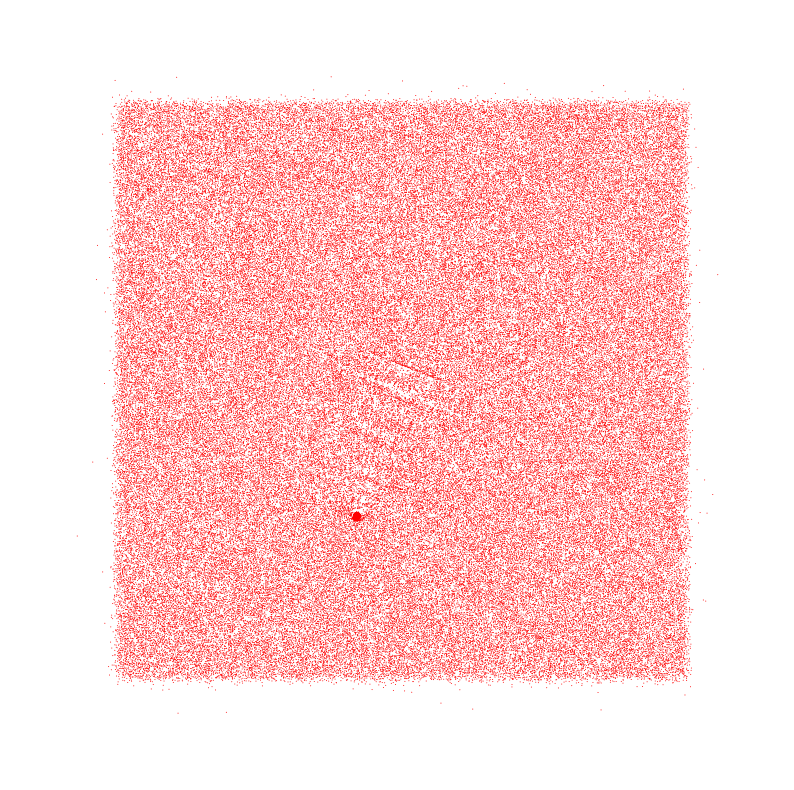

In [75]:
plot_graph(retweet_graph, layout, "retweet_graph.png")

Order: 328823
Size: 1225280
No .of Components: 1
Size of largest component: 328823
Density: 2.2664298765836966e-05
Transitivity: 0.15530632951555542


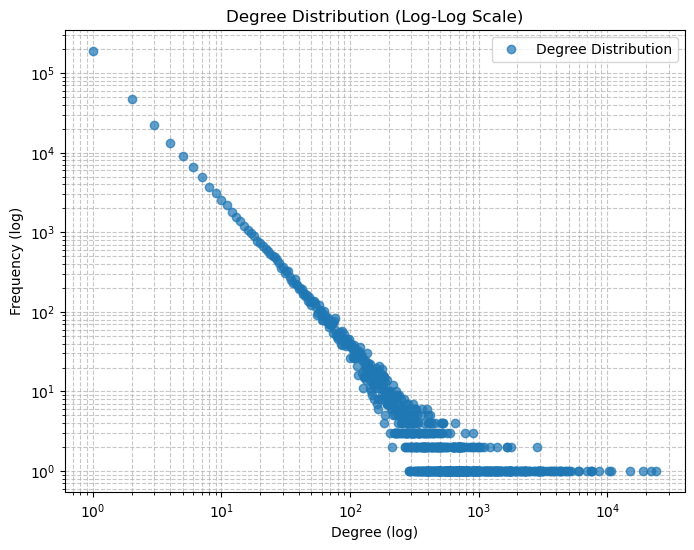

In [19]:
largest_retweet_component = retweet_graph.components().giant()
analyze_graph(largest_retweet_component)

Order: 24553
Size: 28827
No .of Components: 1
Size of largest component: 24553
Density: 9.563965581428792e-05
Transitivity: 0.21998502913719503


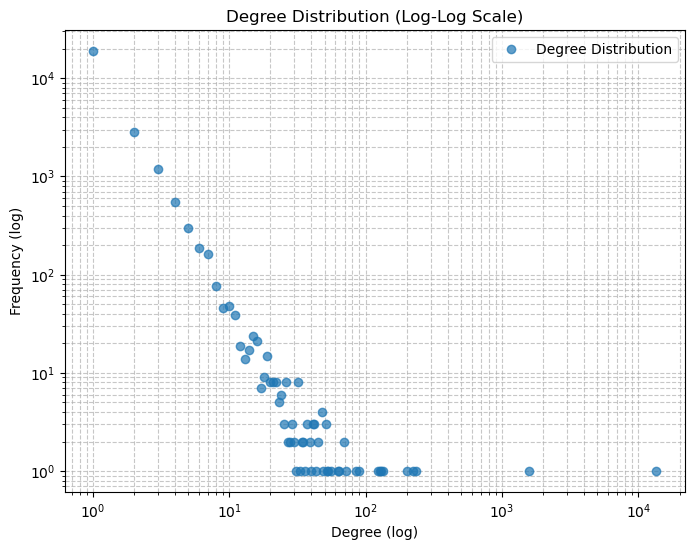

In [20]:
largest_reply_component = reply_graph.components().giant()
analyze_graph(largest_reply_component)

## Task 2

### Part 2.1 ER

In [21]:
order = largest_reply_component.vcount()
prob_distribution = largest_reply_component.ecount() / (order * (order-1) / 2)

ER_reply_graph_1 = ig.Graph.Erdos_Renyi(n=order, p=prob_distribution)
ER_reply_graph_2 = ig.Graph.Erdos_Renyi(n=order, p=prob_distribution)
ER_reply_graph_3 = ig.Graph.Erdos_Renyi(n=order, p=prob_distribution)


Summary of ER_reply_graph_1:
Order: 24553
Size: 28805
No .of Components: 2664
Size of largest component: 21417
Density: 9.556666617166418e-05
Transitivity: 0.0001116649312371621


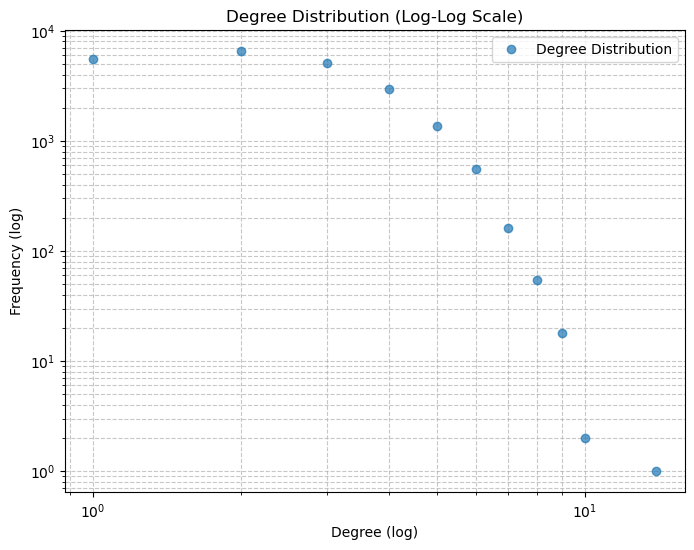

In [22]:
print("Summary of ER_reply_graph_1:")
analyze_graph(ER_reply_graph_1)

Summary of ER_reply_graph_2:
Order: 24553
Size: 28547
No .of Components: 2779
Size of largest component: 21276
Density: 9.47106967263495e-05
Transitivity: 2.810737015398823e-05


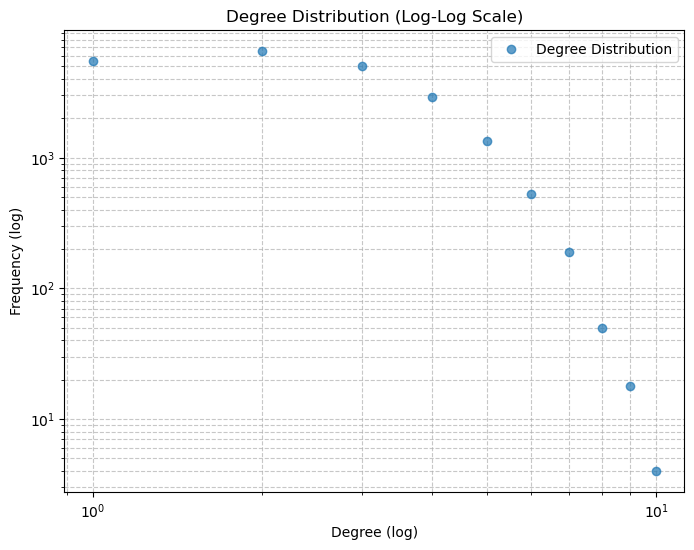

In [23]:
print("Summary of ER_reply_graph_2:")
analyze_graph(ER_reply_graph_2)

Summary of ER_reply_graph_3:
Order: 24553
Size: 28955
No .of Components: 2695
Size of largest component: 21353
Density: 9.606432282591691e-05
Transitivity: 0.00011888447209903445


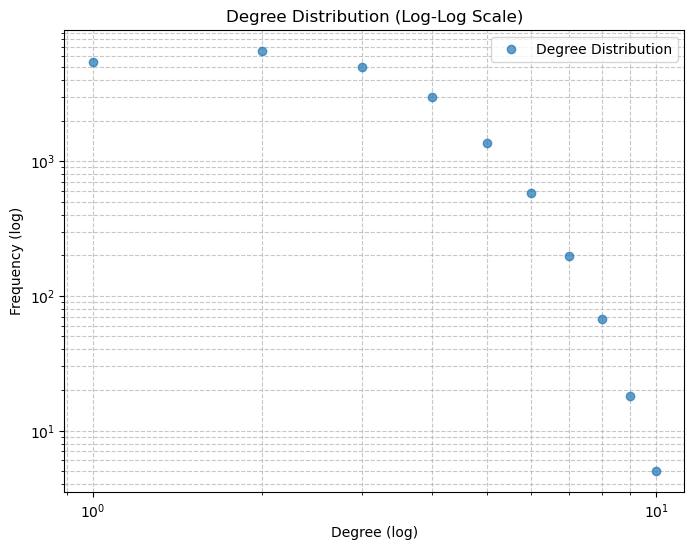

In [24]:
print("Summary of ER_reply_graph_3:")
analyze_graph(ER_reply_graph_3)

In [25]:
retweet_order = largest_retweet_component.vcount()
retweet_prob_distribution = largest_retweet_component.ecount() / (retweet_order * (retweet_order-1) / 2)

ER_retweet_graph_1 = ig.Graph.Erdos_Renyi(n=retweet_order, p=retweet_prob_distribution)
ER_retweet_graph_2 = ig.Graph.Erdos_Renyi(n=retweet_order, p=retweet_prob_distribution)
ER_retweet_graph_3 = ig.Graph.Erdos_Renyi(n=retweet_order, p=retweet_prob_distribution)

Summary of ER_retweet_graph_1:
Order: 328823
Size: 1226316
No .of Components: 211
Size of largest component: 328612
Density: 2.2683461906932394e-05
Transitivity: 1.9176959670562293e-05


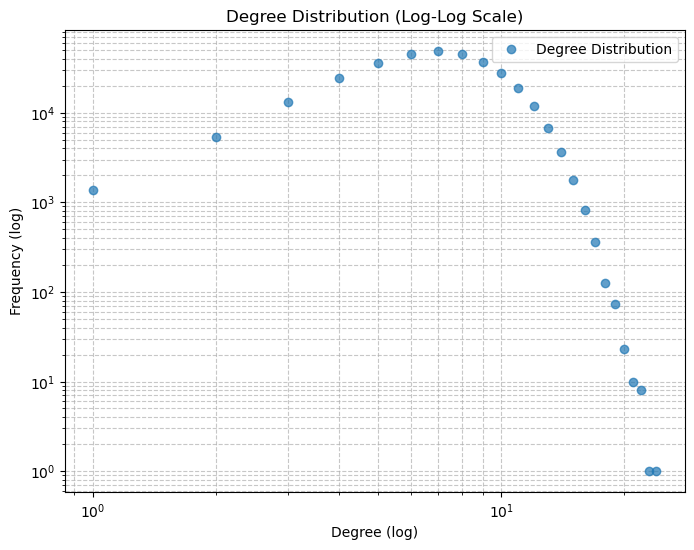

In [26]:
print("Summary of ER_retweet_graph_1:")
analyze_graph(ER_retweet_graph_1)

Summary of ER_retweet_graph_2:
Order: 328823
Size: 1223297
No .of Components: 183
Size of largest component: 328641
Density: 2.2627618738045234e-05
Transitivity: 2.0760751790470973e-05


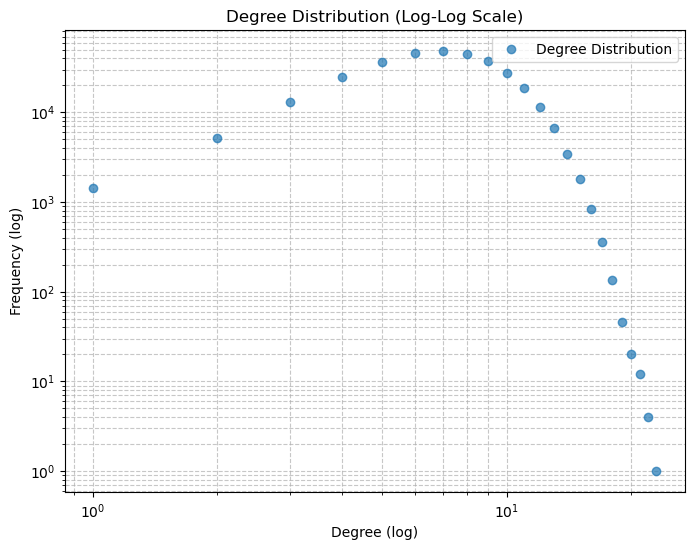

In [27]:
print("Summary of ER_retweet_graph_2:")
analyze_graph(ER_retweet_graph_2)

Summary of ER_retweet_graph_3:
Order: 328823
Size: 1224806
No .of Components: 188
Size of largest component: 328636
Density: 2.2655531073868593e-05
Transitivity: 2.256249566878084e-05


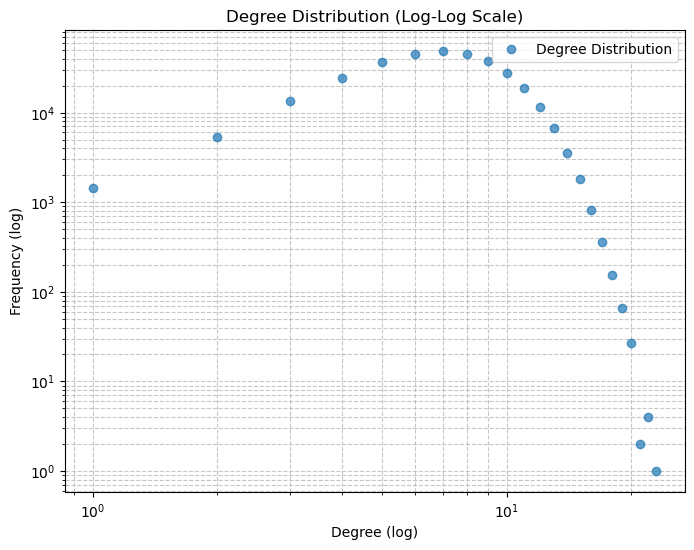

In [28]:
print("Summary of ER_retweet_graph_3:")
analyze_graph(ER_retweet_graph_3)

### Part-2 Barabasi-Albert

In [29]:
retweet_avg_degree = largest_retweet_component.ecount()/retweet_order
m = round(retweet_avg_degree)

BA_retweet_graph_1 = ig.Graph.Barabasi(n=retweet_order, m=m)
BA_retweet_graph_2 = ig.Graph.Barabasi(n=retweet_order, m=m)
BA_retweet_graph_3 = ig.Graph.Barabasi(n=retweet_order, m=m)

Summary of BA_retweet_graph_1:
Order: 328823
Size: 1315282
No .of Components: 1
Size of largest component: 328823
Density: 2.4329087399882132e-05
Transitivity: 0.00019698924630510238


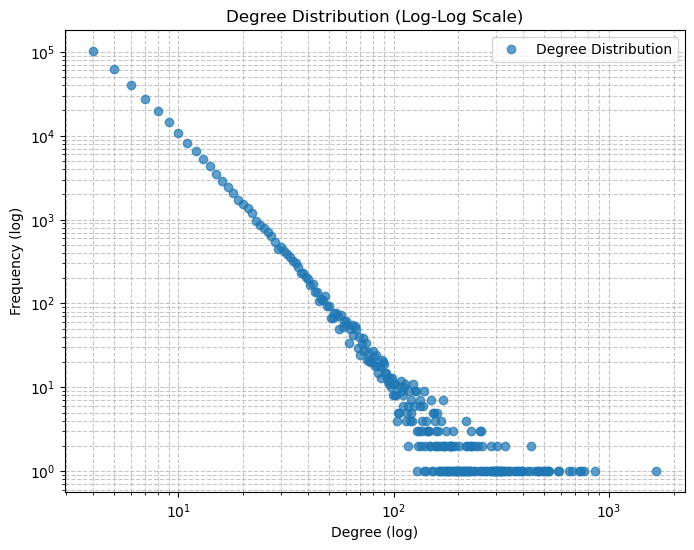

In [30]:
print("Summary of BA_retweet_graph_1:")
analyze_graph(BA_retweet_graph_1)

Summary of BA_retweet_graph_2:
Order: 328823
Size: 1315282
No .of Components: 1
Size of largest component: 328823
Density: 2.4329087399882132e-05
Transitivity: 0.00022319841403019354


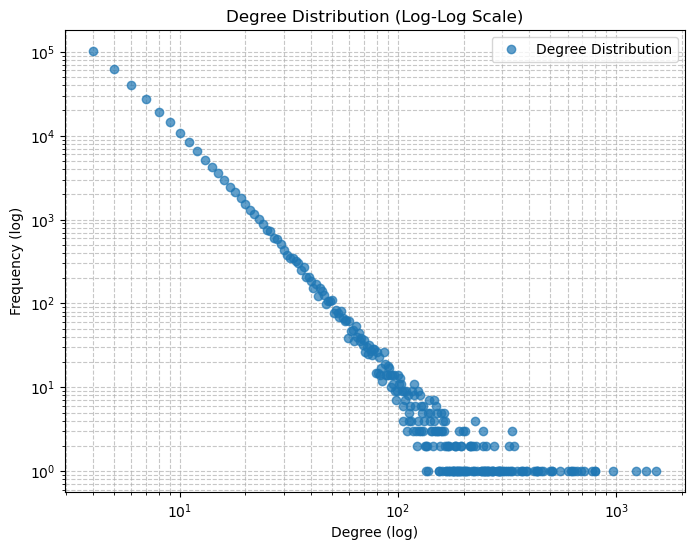

In [31]:
print("Summary of BA_retweet_graph_2:")
analyze_graph(BA_retweet_graph_2)

Summary of BA_retweet_graph_3:
Order: 328823
Size: 1315282
No .of Components: 1
Size of largest component: 328823
Density: 2.4329087399882132e-05
Transitivity: 0.00020070981273315175


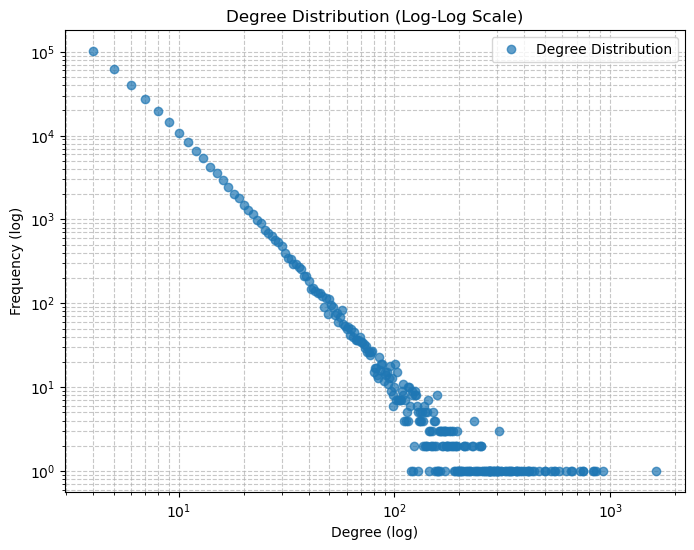

In [32]:
print("Summary of BA_retweet_graph_3:")
analyze_graph(BA_retweet_graph_3)

In [33]:
reply_avg_degree = largest_reply_component.ecount() / order
m_reply = round(reply_avg_degree)
# print(m_reply)
BA_reply_graph_1 = ig.Graph.Barabasi(n=order, m=m_reply)
BA_reply_graph_2 = ig.Graph.Barabasi(n=order, m=m_reply)
BA_reply_graph_3 = ig.Graph.Barabasi(n=order, m=m_reply)

Summary of BA_reply_graph_1:
Order: 24553
Size: 24552
No .of Components: 1
Size of largest component: 24553
Density: 8.145644116808537e-05
Transitivity: 0.0


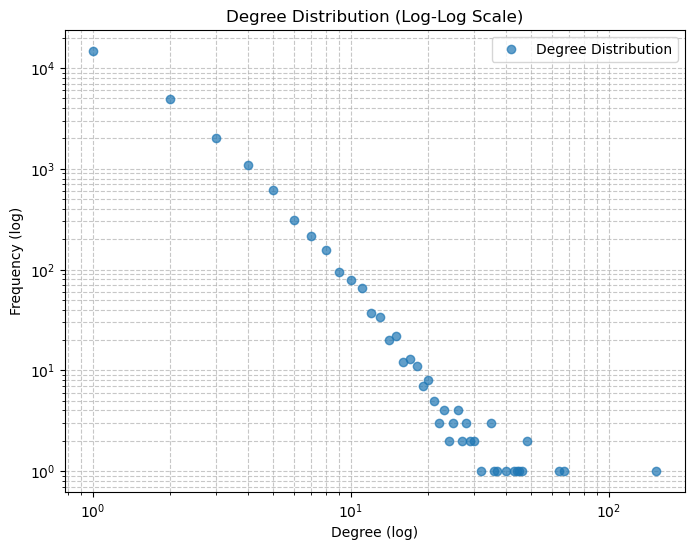

In [34]:
print("Summary of BA_reply_graph_1:")
analyze_graph(BA_reply_graph_1)

Summary of BA_reply_graph_2:
Order: 24553
Size: 24552
No .of Components: 1
Size of largest component: 24553
Density: 8.145644116808537e-05
Transitivity: 0.0


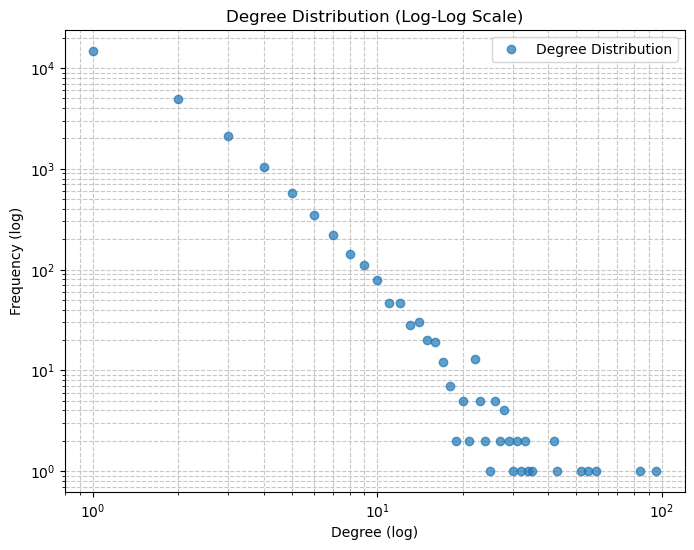

In [35]:
print("Summary of BA_reply_graph_2:")
analyze_graph(BA_reply_graph_2)

Summary of BA_reply_graph_3:
Order: 24553
Size: 24552
No .of Components: 1
Size of largest component: 24553
Density: 8.145644116808537e-05
Transitivity: 0.0


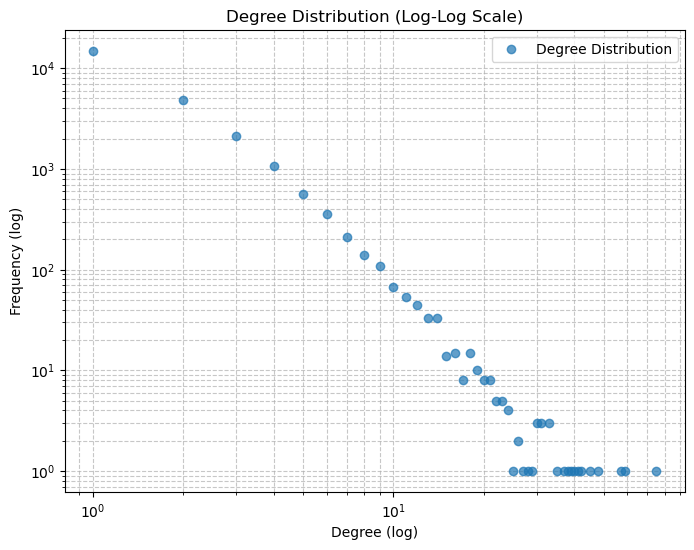

In [36]:
print("Summary of BA_reply_graph_3:")
analyze_graph(BA_reply_graph_3)

### Part-3 WS or Small World

In [37]:
reply_avg_path_length = round(largest_reply_component.average_path_length())

WS_reply_graph_1 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=reply_avg_path_length, p=0.5)
WS_reply_graph_2 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=reply_avg_path_length, p=0.9999999999)
WS_reply_graph_3 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=reply_avg_path_length, p=1)

Summary of WS_reply_graph_1: with p=0.5
Order: 24553
Size: 73659
No .of Components: 21
Size of largest component: 24533
Density: 0.00024437927663734115
Transitivity: 0.010414911154974865


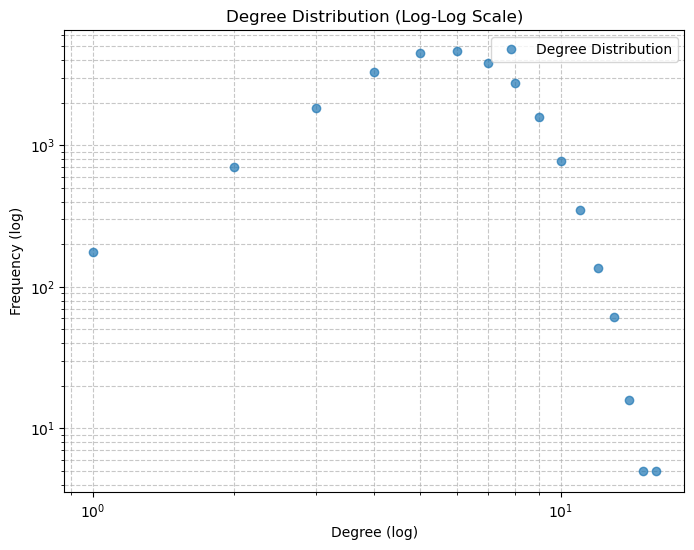

Avg path length: 5.940213914992886


In [38]:
print("Summary of WS_reply_graph_1: with p=0.5")
analyze_graph(WS_reply_graph_1)
print("Avg path length:", WS_reply_graph_1.average_path_length())
# print("Clustering coefficient:", WS_reply_graph_1.transitivity_undirected())

Summary of WS_reply_graph_2: with p=0.99999999999
Order: 24553
Size: 73659
No .of Components: 80
Size of largest component: 24473
Density: 0.00024437927663734115
Transitivity: 0.00033259545818610693


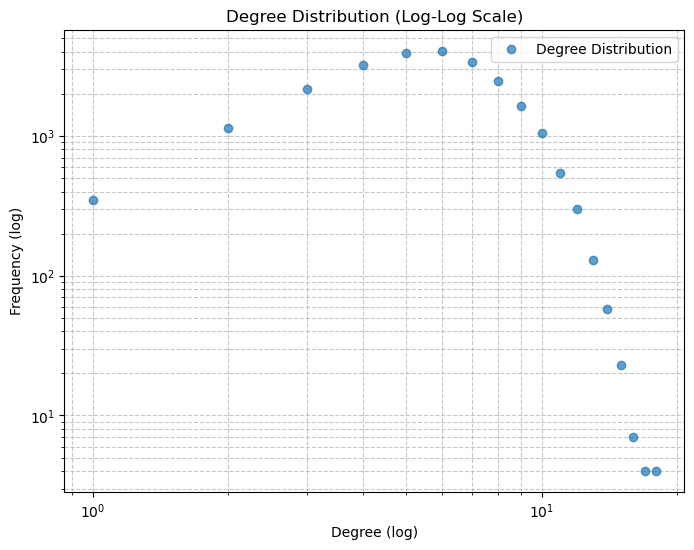

Avg path length: 5.838785138149975


In [39]:
print("Summary of WS_reply_graph_2: with p=0.99999999999")
analyze_graph(WS_reply_graph_2)
print("Avg path length:", WS_reply_graph_2.average_path_length())
# print("Clustering coefficient:", WS_reply_graph_2.transitivity_undirected())

Summary of WS_reply_graph_3: with p=1
Order: 24553
Size: 73659
No .of Components: 55
Size of largest component: 24499
Density: 0.00024437927663734115
Transitivity: 0.0002471554300064124


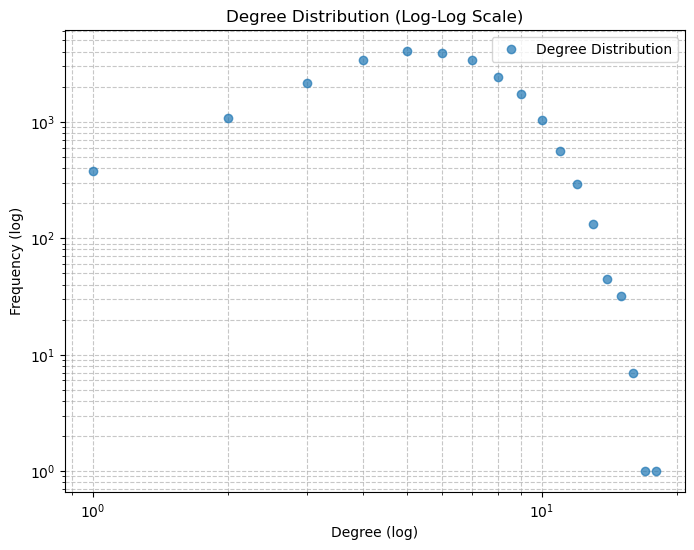

Avg path length: 5.844340906902083


In [40]:
print("Summary of WS_reply_graph_3: with p=1")
analyze_graph(WS_reply_graph_3)
print("Avg path length:", WS_reply_graph_3.average_path_length())
# print("Clustering coefficient:", WS_reply_graph_3.transitivity_undirected())

In [41]:
retweet_avg_path_length = round(largest_retweet_component.average_path_length())

WS_retweet_graph_1 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=retweet_avg_path_length, p=0.5)
WS_retweet_graph_2 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=retweet_avg_path_length, p=0.9999999999)
WS_retweet_graph_3 = ig.Graph.Watts_Strogatz(dim=1, size=order, nei=retweet_avg_path_length, p=1)

Summary of WS_reply_graph_1: with p=0.5
Order: 24553
Size: 98212
No .of Components: 4
Size of largest component: 24550
Density: 0.00032583903551645487
Transitivity: 0.010712901992709096


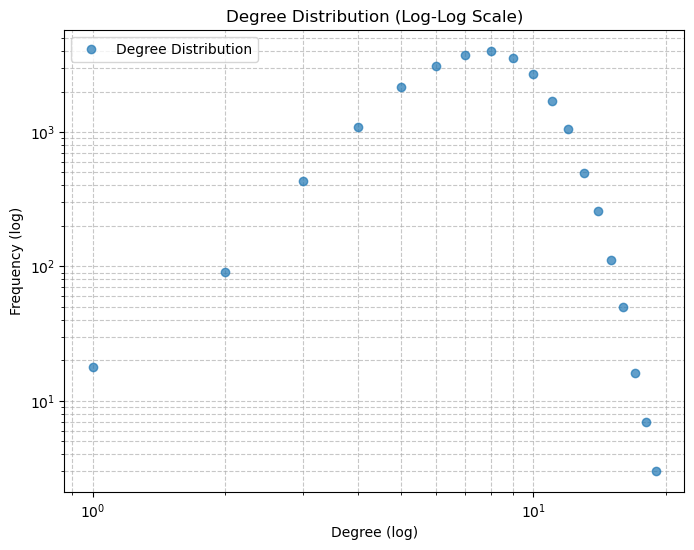

Avg path length: 5.153603887449342


In [42]:
print("Summary of WS_reply_graph_1: with p=0.5")
analyze_graph(WS_retweet_graph_1)
print("Avg path length:", WS_retweet_graph_1.average_path_length())

Summary of WS_reply_graph_2: with p=0.9999999999
Order: 24553
Size: 98212
No .of Components: 11
Size of largest component: 24543
Density: 0.00032583903551645487
Transitivity: 0.0004226013811454253


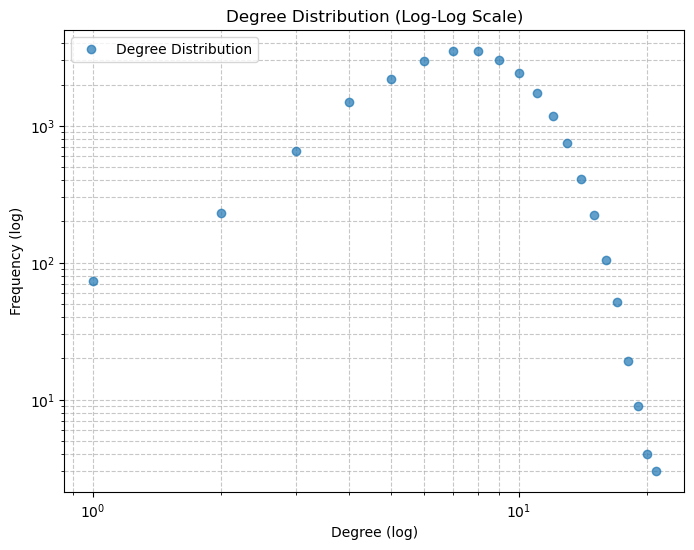

Avg path length: 5.097806559269762


In [43]:
print("Summary of WS_reply_graph_2: with p=0.9999999999")
analyze_graph(WS_retweet_graph_2)
print("Avg path length:", WS_retweet_graph_2.average_path_length())

Summary of WS_reply_graph_3: with p=1
Order: 24553
Size: 98212
No .of Components: 16
Size of largest component: 24538
Density: 0.00032583903551645487
Transitivity: 0.00035326885740251553


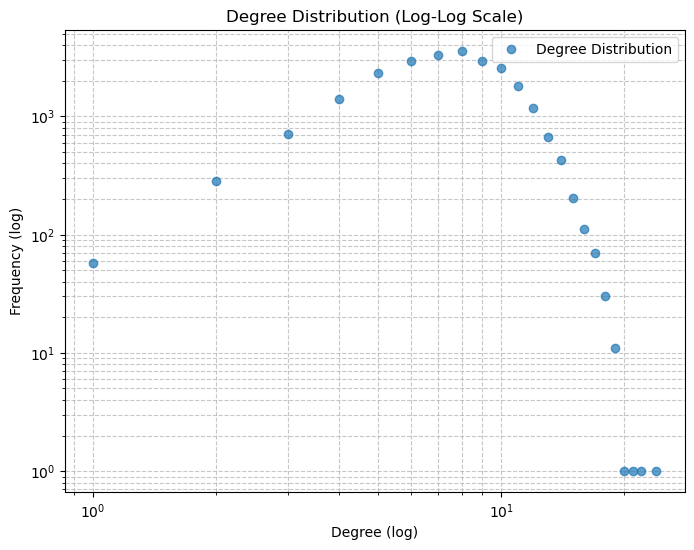

Avg path length: 5.094777212187996


In [44]:
print("Summary of WS_reply_graph_3: with p=1")
analyze_graph(WS_retweet_graph_3)
print("Avg path length:", WS_retweet_graph_3.average_path_length())

### Part-4 Rewire

Order: 24553
Size: 28827
No .of Components: 1537
Size of largest component: 21338
Density: 9.563965581428792e-05
Transitivity: 0.31094612646305014


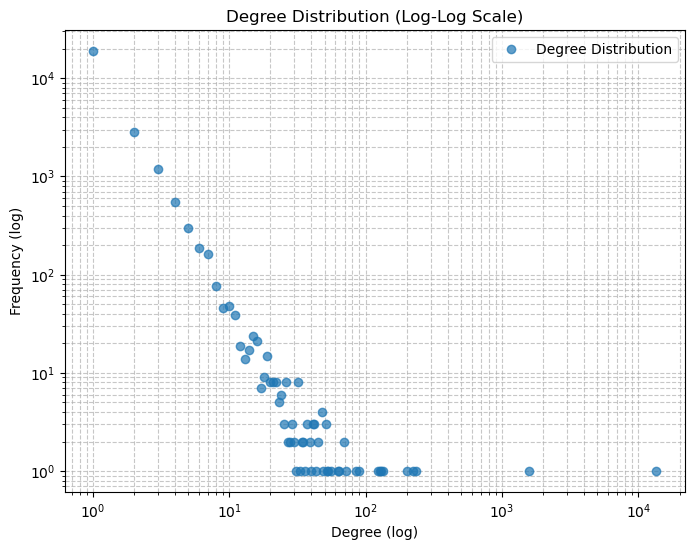

In [45]:
rewired_reply_graph = largest_reply_component.copy()
rewired_reply_graph.rewire()
analyze_graph(rewired_reply_graph)

Order: 328823
Size: 1225280
No .of Components: 6035
Size of largest component: 316528
Density: 2.2664298765836966e-05
Transitivity: 0.16344620325681727


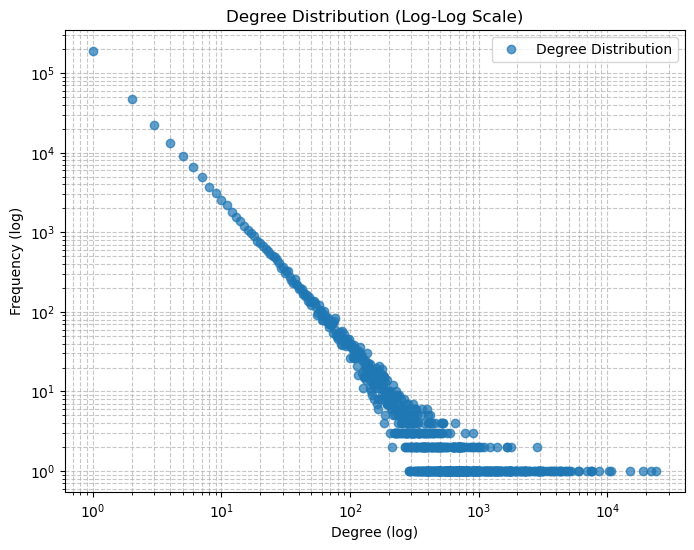

In [46]:
rewired_retweet_graph = largest_retweet_component.copy()
rewired_retweet_graph.rewire()
analyze_graph(rewired_retweet_graph)

## Task-3

### Task-3.1

In [47]:
import random

In [48]:
def random_walk(g: ig.Graph, actor: ig.Vertex, iterations: int = 10_000) -> list:
    token_counts = [0] * g.vcount()
    for iter in range(iterations):
        token_counts[actor.index] += 1
        actor = random.choice(actor.neighbors())

    token_ratios = np.array(token_counts) / iterations
    return token_ratios.tolist()
        
    

In [55]:
starting_index = random.randint(0, largest_reply_component.vcount()-1)
start_reply_net = largest_reply_component.vs[starting_index]
print(start_reply_net["name"])

3331486504


In [57]:
reply_net_ratios = random_walk(largest_reply_component, start_reply_net, iterations=2 * largest_reply_component.vcount())
print(reply_net_ratios)
print(max(reply_net_ratios))
largest_reply_component.vs["reply_ratios"] = reply_net_ratios

[2.0364110292021342e-05, 0.0, 0.0, 2.0364110292021342e-05, 4.0728220584042684e-05, 0.0, 0.0, 2.0364110292021342e-05, 0.00012218466175212804, 0.0, 4.0728220584042684e-05, 2.0364110292021342e-05, 2.0364110292021342e-05, 2.0364110292021342e-05, 4.0728220584042684e-05, 2.0364110292021342e-05, 0.0, 4.0728220584042684e-05, 0.00012218466175212804, 0.0, 0.0, 0.0003461898749643628, 0.0, 0.0, 6.109233087606402e-05, 0.0, 0.0, 0.00014254877204414939, 8.145644116808537e-05, 0.0, 4.0728220584042684e-05, 4.0728220584042684e-05, 0.0, 0.0, 4.0728220584042684e-05, 0.0, 0.0, 4.0728220584042684e-05, 0.00012218466175212804, 0.0, 0.0, 6.109233087606402e-05, 2.0364110292021342e-05, 4.0728220584042684e-05, 0.00018327699262819208, 4.0728220584042684e-05, 0.0, 0.00012218466175212804, 8.145644116808537e-05, 2.0364110292021342e-05, 0.0, 0.00012218466175212804, 4.0728220584042684e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 6.109233087606402e-05, 4.0728220584042684e-05, 0.00012218466175212804, 4.0728220584042684e-05, 6.109233087

In [59]:
largest_reply_component_order = largest_reply_component.vcount()
# small-world
nei = round(largest_reply_component.average_path_length())
swg = ig.Graph.Watts_Strogatz(dim=1, size=largest_reply_component_order, nei=nei, p=0.16)
swg.vs["reply_ratios"] = random_walk(swg, swg.vs[starting_index], iterations = 2 * largest_reply_component_order)

# Erdos Reyni
prob_distribution = largest_reply_component.ecount() / (largest_reply_component_order * (largest_reply_component_order-1) / 2)
erg = ig.Graph.Erdos_Renyi(n=largest_reply_component_order, p=prob_distribution)
erg.vs["reply_ratios"] = random_walk(erg, erg.vs[starting_index], iterations = 2 * largest_reply_component_order)

# Barabasi Albert
avg_degree = largest_reply_component.ecount() / largest_reply_component_order
m = round(avg_degree)
bag = ig.Graph.Barabasi(n=largest_reply_component_order, m=m)
bag.vs["reply_ratios"] = random_walk(bag, bag.vs[starting_index], iterations = 2 * largest_reply_component_order)

# Rewired
rewired = largest_reply_component.copy()
rewired.rewire()
rewired.vs["reply_ratios"] = random_walk(rewired, rewired.vs[starting_index], iterations = 2 * largest_reply_component_order)

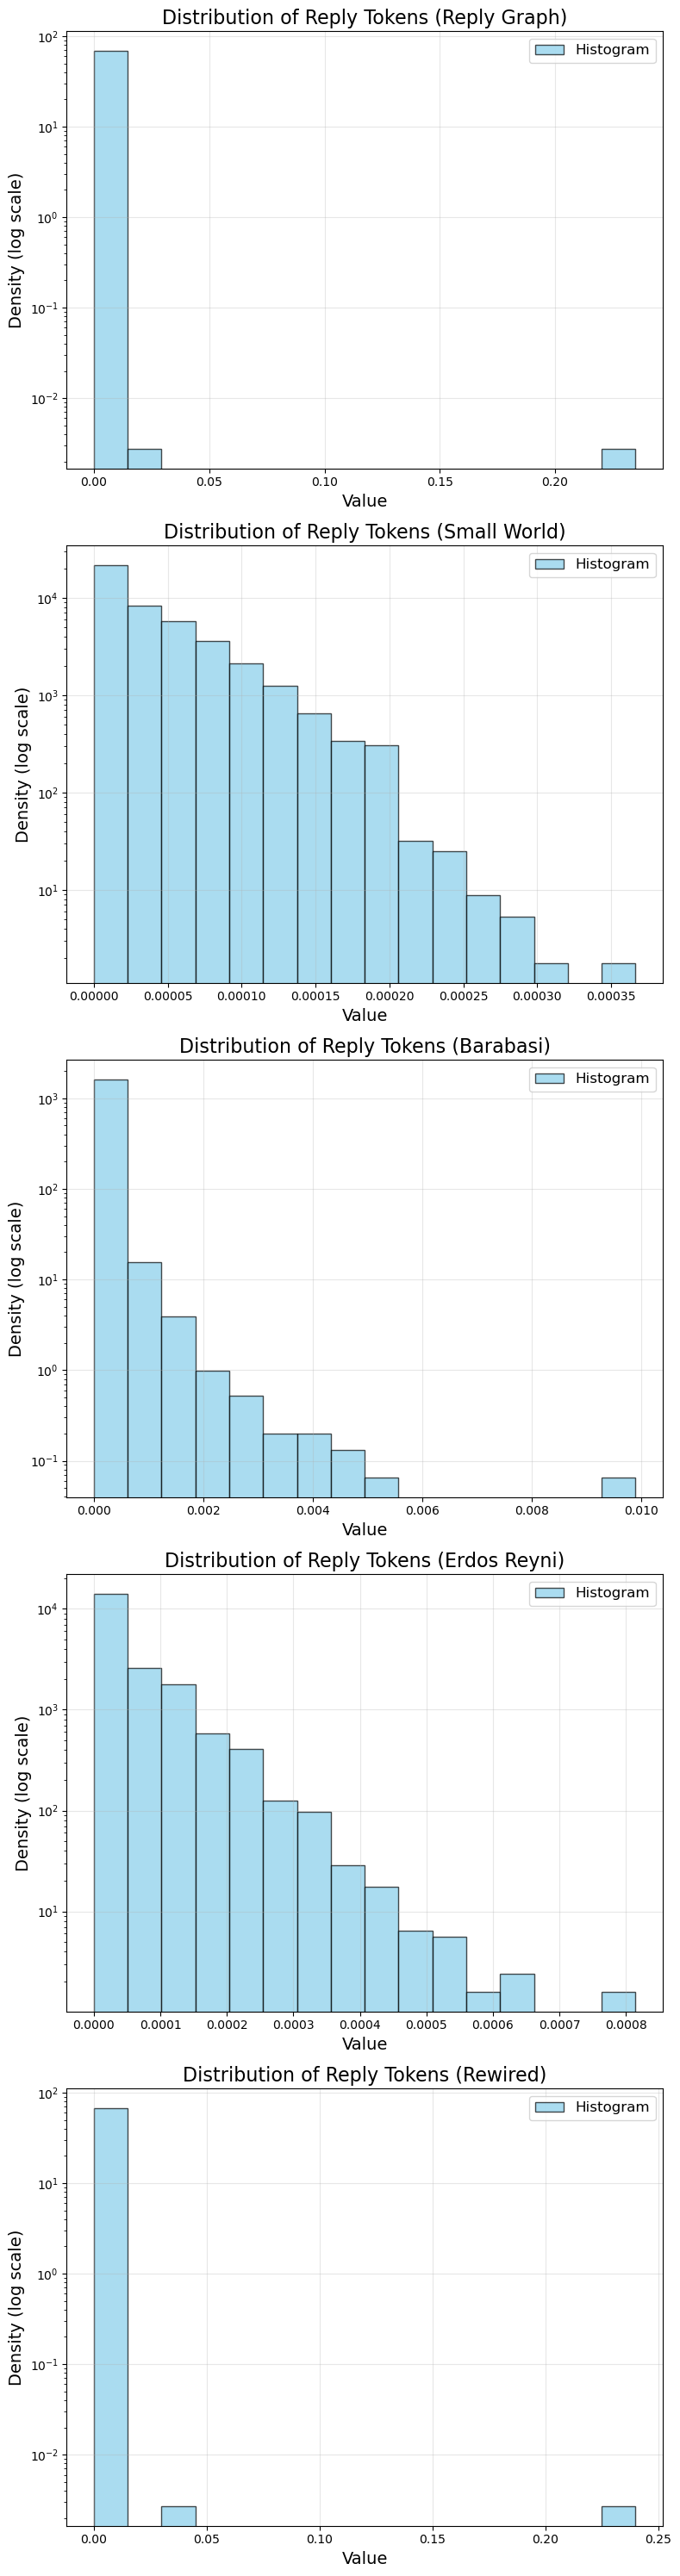

In [61]:
datasets = {
    "Reply Graph": largest_reply_component.vs["reply_ratios"],
    "Small World": swg.vs["reply_ratios"],
    "Barabasi": bag.vs["reply_ratios"],
    "Erdos Reyni": erg.vs["reply_ratios"],
    "Rewired": rewired.vs["reply_ratios"],
}

num_datasets = len(datasets)
fig, axes = plt.subplots(nrows=num_datasets, ncols=1, figsize=(8, 6 * num_datasets))
for ax, (label, data) in zip(axes, datasets.items()):
    ax.hist(data, bins=16, density=True, color="skyblue", edgecolor="black", alpha=0.7, label="Histogram")

    ax.set_title(f"Distribution of Reply Tokens ({label})", fontsize=16)
    ax.set_xlabel("Value", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Density (log scale)", fontsize=14)

    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Task 3.2

In [62]:
def random_diffusion(g: ig.Graph, actor: ig.Vertex = None, beta: float = 0.05, iterations: int = 100) -> list:
    if actor is None:
        actor = g.vs[random.randint(0, g.vcount() - 1)]
    infected = set([actor.index])

    for _ in range(iterations):
        infected_actors: ig.seq.VertexSeq = g.vs[list(infected)]
        for infected_actor in infected_actors:
            neighbors = infected_actor.neighbors()
            weights = [beta] * len(neighbors)
            infected_neighbors = random.choices(neighbors, weights=weights, k=len(neighbors))
            infected.update([n.index for n in infected_neighbors])
        if len(infected) == g.vcount():
            print(f"All nodes infected after {_} rounds.")
            break

    return list(infected), len(infected)

In [64]:
random_diff = random_diffusion(largest_reply_component, iterations=1000, beta=0.00000000000000000000000000000000000001)
print(f"{len(random_diff[0]) / largest_reply_component.vcount()}%")
print(random_diff[1])

All nodes infected after 13 rounds.
1.0%
24553


In [65]:
pairs = [(largest_reply_component, "reply"), (swg, "SW"), (bag, "BA"), (rewired, "rewire"), (erg, "ER")]

In [66]:
bootstrap_rounds = 5
betas = [0.001, 0.01, 0.05]
results = []
for pair in pairs:
    graph: ig.Graph = pair[0]
    graph_name = pair[1]
    print(f"Running {graph_name}")
    trans = graph.transitivity_avglocal_undirected()
    avg_path = graph.average_path_length()
    for _ in range(bootstrap_rounds):
        start_index = random.randint(0, graph.vcount() - 1)
        start_node: ig.Vertex = graph.vs[start_index]
        start_neighbors = len(start_node.neighbors())
        start_betweenness = start_node.betweenness()
        for beta in betas:
            iterations = 10
            _, infected_count = random_diffusion(graph, actor=start_node, beta=beta, iterations=iterations)
            result = {
                "graph": graph_name,
                "start_index": start_index,
                "starting_neighbors": start_neighbors,
                "starting_betweenness": start_betweenness,
                "transitivity": trans,
                "components": len(graph.components()),
                "beta": beta,
                "average_path": avg_path,
                "iterations": iterations,
                "number_infected": infected_count
            }
            results.append(result)
res_df = pd.DataFrame(results)

Running reply
Running SW
Running BA
Running rewire
Running ER


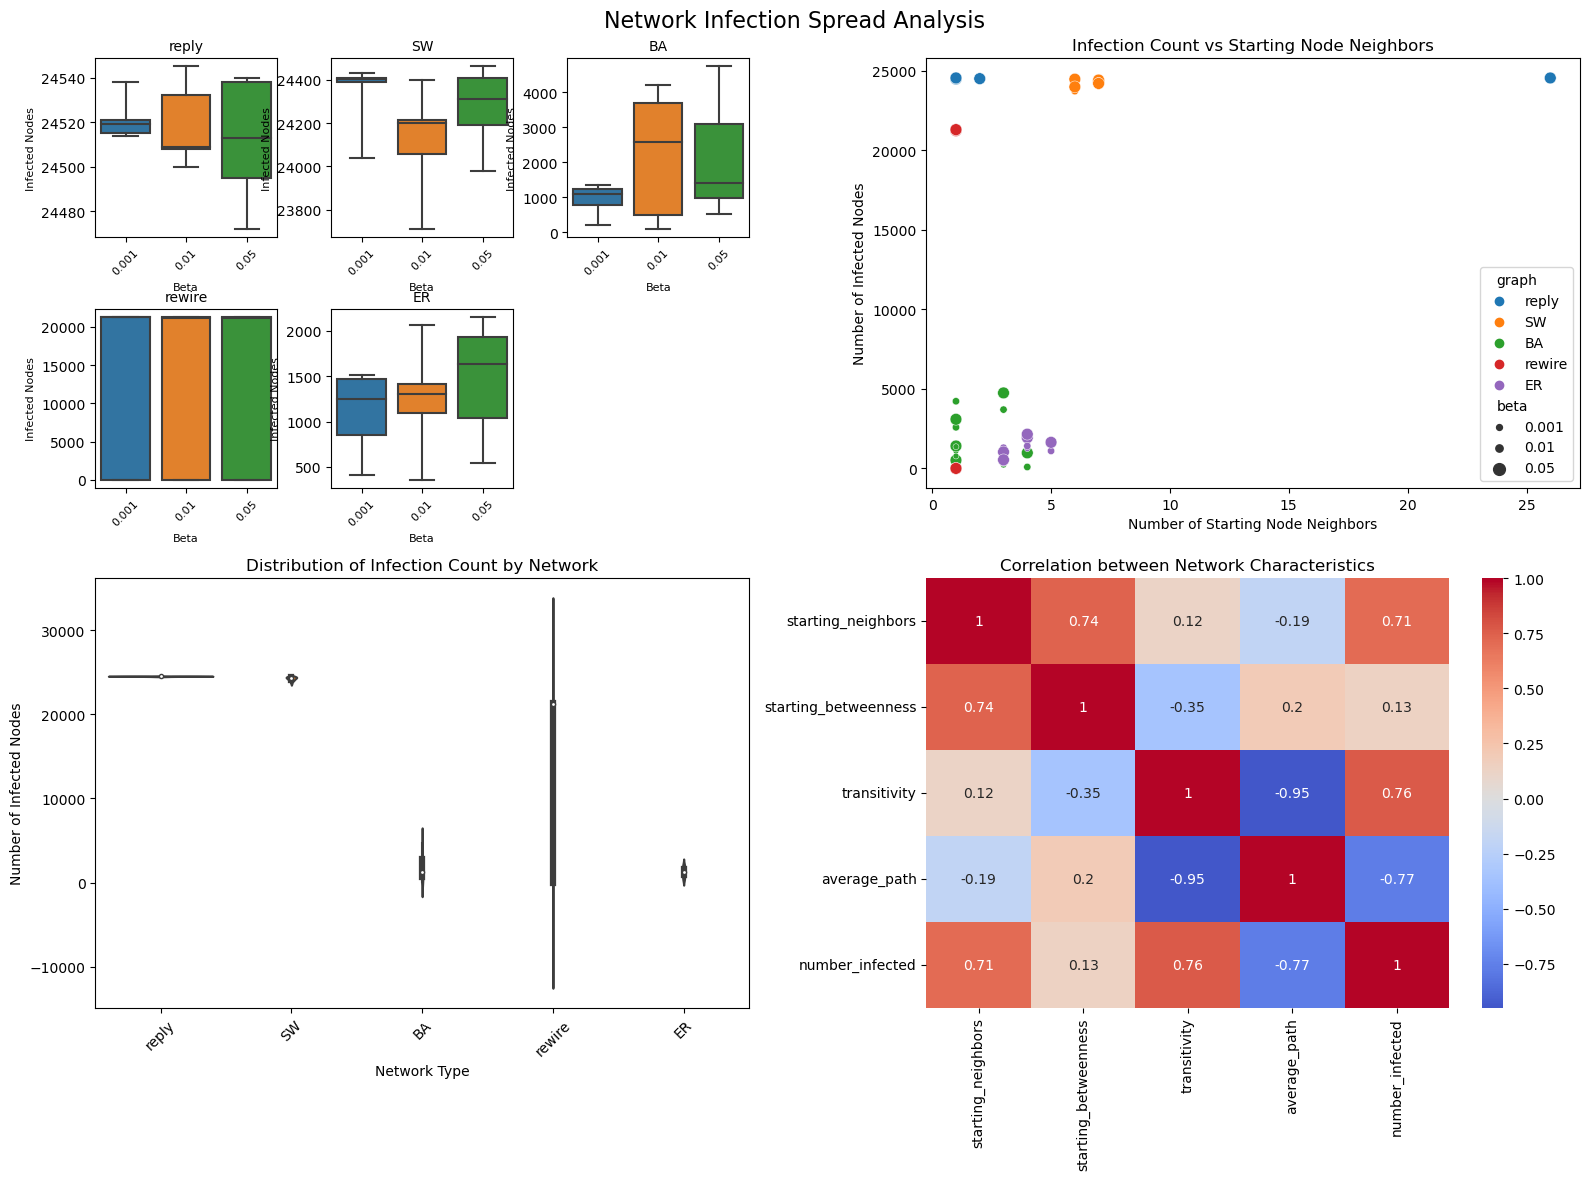

In [69]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2)
# Create a nested grid for the first subplot area
gs_inner = gs[0, 0].subgridspec(2, 3, wspace=0.3, hspace=0.4)
fig.suptitle('Network Infection Spread Analysis', fontsize=16)
# Multiple Boxplots of Infection Count by Beta
graphs = res_df['graph'].unique()
for i, graph in enumerate(graphs):
    graph_data = res_df[res_df['graph'] == graph]
    # Determine the subplot position
    row = i // 3
    col = i % 3
    # Create subplot in the inner grid
    ax_inner = fig.add_subplot(gs_inner[row, col])
    sns.boxplot(x='beta', y='number_infected', 
                data=graph_data,
                showfliers=False,
                whis=[0, 100],
                ax=ax_inner)
    ax_inner.set_title(graph, fontsize=10)
    ax_inner.tick_params(axis='x', rotation=45, labelsize=8)
    ax_inner.set_xlabel('Beta', fontsize=8)
    ax_inner.set_ylabel('Infected Nodes', fontsize=8)
# Scatter plot of Starting Neighbors vs Infection Count
ax2 = fig.add_subplot(gs[0, 1])
scatter = sns.scatterplot(x='starting_neighbors', y='number_infected', 
                           hue='graph', size='beta', 
                           data=res_df, ax=ax2)
ax2.set_title('Infection Count vs Starting Node Neighbors')
ax2.set_xlabel('Number of Starting Node Neighbors')
ax2.set_ylabel('Number of Infected Nodes')
# Violin plot of Infection Count by Network
ax3 = fig.add_subplot(gs[1, 0])
sns.violinplot(x='graph', y='number_infected', 
               data=res_df, ax=ax3)
ax3.set_title('Distribution of Infection Count by Network')
ax3.set_xlabel('Network Type')
ax3.set_ylabel('Number of Infected Nodes')
ax3.tick_params(axis='x', rotation=45)
# Heatmap of Correlation between Network Characteristics and Infection
ax4 = fig.add_subplot(gs[1, 1])
correlation_df = res_df.groupby('graph').agg({
    'starting_neighbors': 'mean',
    'starting_betweenness': 'mean',
    'transitivity': 'mean',
    'average_path': 'mean',
    'number_infected': 'mean'
}).reset_index()

correlation_matrix = correlation_df.set_index('graph').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            center=0, ax=ax4)
ax4.set_title('Correlation between Network Characteristics')

plt.tight_layout()
plt.show()

### Task 3.3

In [70]:
def random_opinion(g: ig.Graph, th: int, initial_positive: int, iterations: int = 100) -> list:
    """
    Note: Some bug with random.choices can make the initial postive count less
    than what you pass in. idk, calling it good enough and moving on.
    """
    g = g.copy()
    g.vs["convinced"] = False
    starting_indices = random.choices([i for i in range(g.vcount())], k=initial_positive)
    g.vs[starting_indices]["convinced"] = True  # bug here

    for _ in range(iterations):
        convinced_actors: ig.VertexSeq = g.vs.select(convinced_eq=True)
        for actor in convinced_actors:
            neighbors = actor.neighbors()
            if sum([n["convinced"] for n in neighbors]) > th:
                g.vs[[n.index for n in neighbors]]["convinced"] = True

    return len(g.vs.select(convinced_eq=True))

In [71]:
bootstrap_rounds = 10
initial_positive = [1_000, 5_000, 10_000, 15_000]
thresholds = [5, 10, 20]
results = []
for pair in pairs:
    graph: ig.Graph = pair[0]
    graph_name = pair[1]
    print(f"Running {graph_name}")
    trans = graph.transitivity_avglocal_undirected()
    avg_path = graph.average_path_length()
    for _ in range(bootstrap_rounds):
        start_index = random.randint(0, graph.vcount() - 1)
        start_node: ig.Vertex = graph.vs[start_index]
        start_neighbors = len(start_node.neighbors())
        start_betweenness = start_node.betweenness()
        for thresh in thresholds:
            for init in initial_positive:
                iterations = 5
                convinced_count = random_opinion(graph, th=thresh, initial_positive=init, iterations=iterations)
                result = {
                    "graph": graph_name,
                    "start_index": start_index,
                    "starting_neighbors": start_neighbors,
                    "starting_betweenness": start_betweenness,
                    "transitivity": trans,
                    "components": len(graph.components()),
                    "initial_positive": init,
                    "average_path": avg_path,
                    "iterations": iterations,
                    "threshold": thresh,
                    "number_convinced": convinced_count
                }
                results.append(result)
opinion_df = pd.DataFrame(results)

Running reply
Running SW
Running BA
Running rewire
Running ER


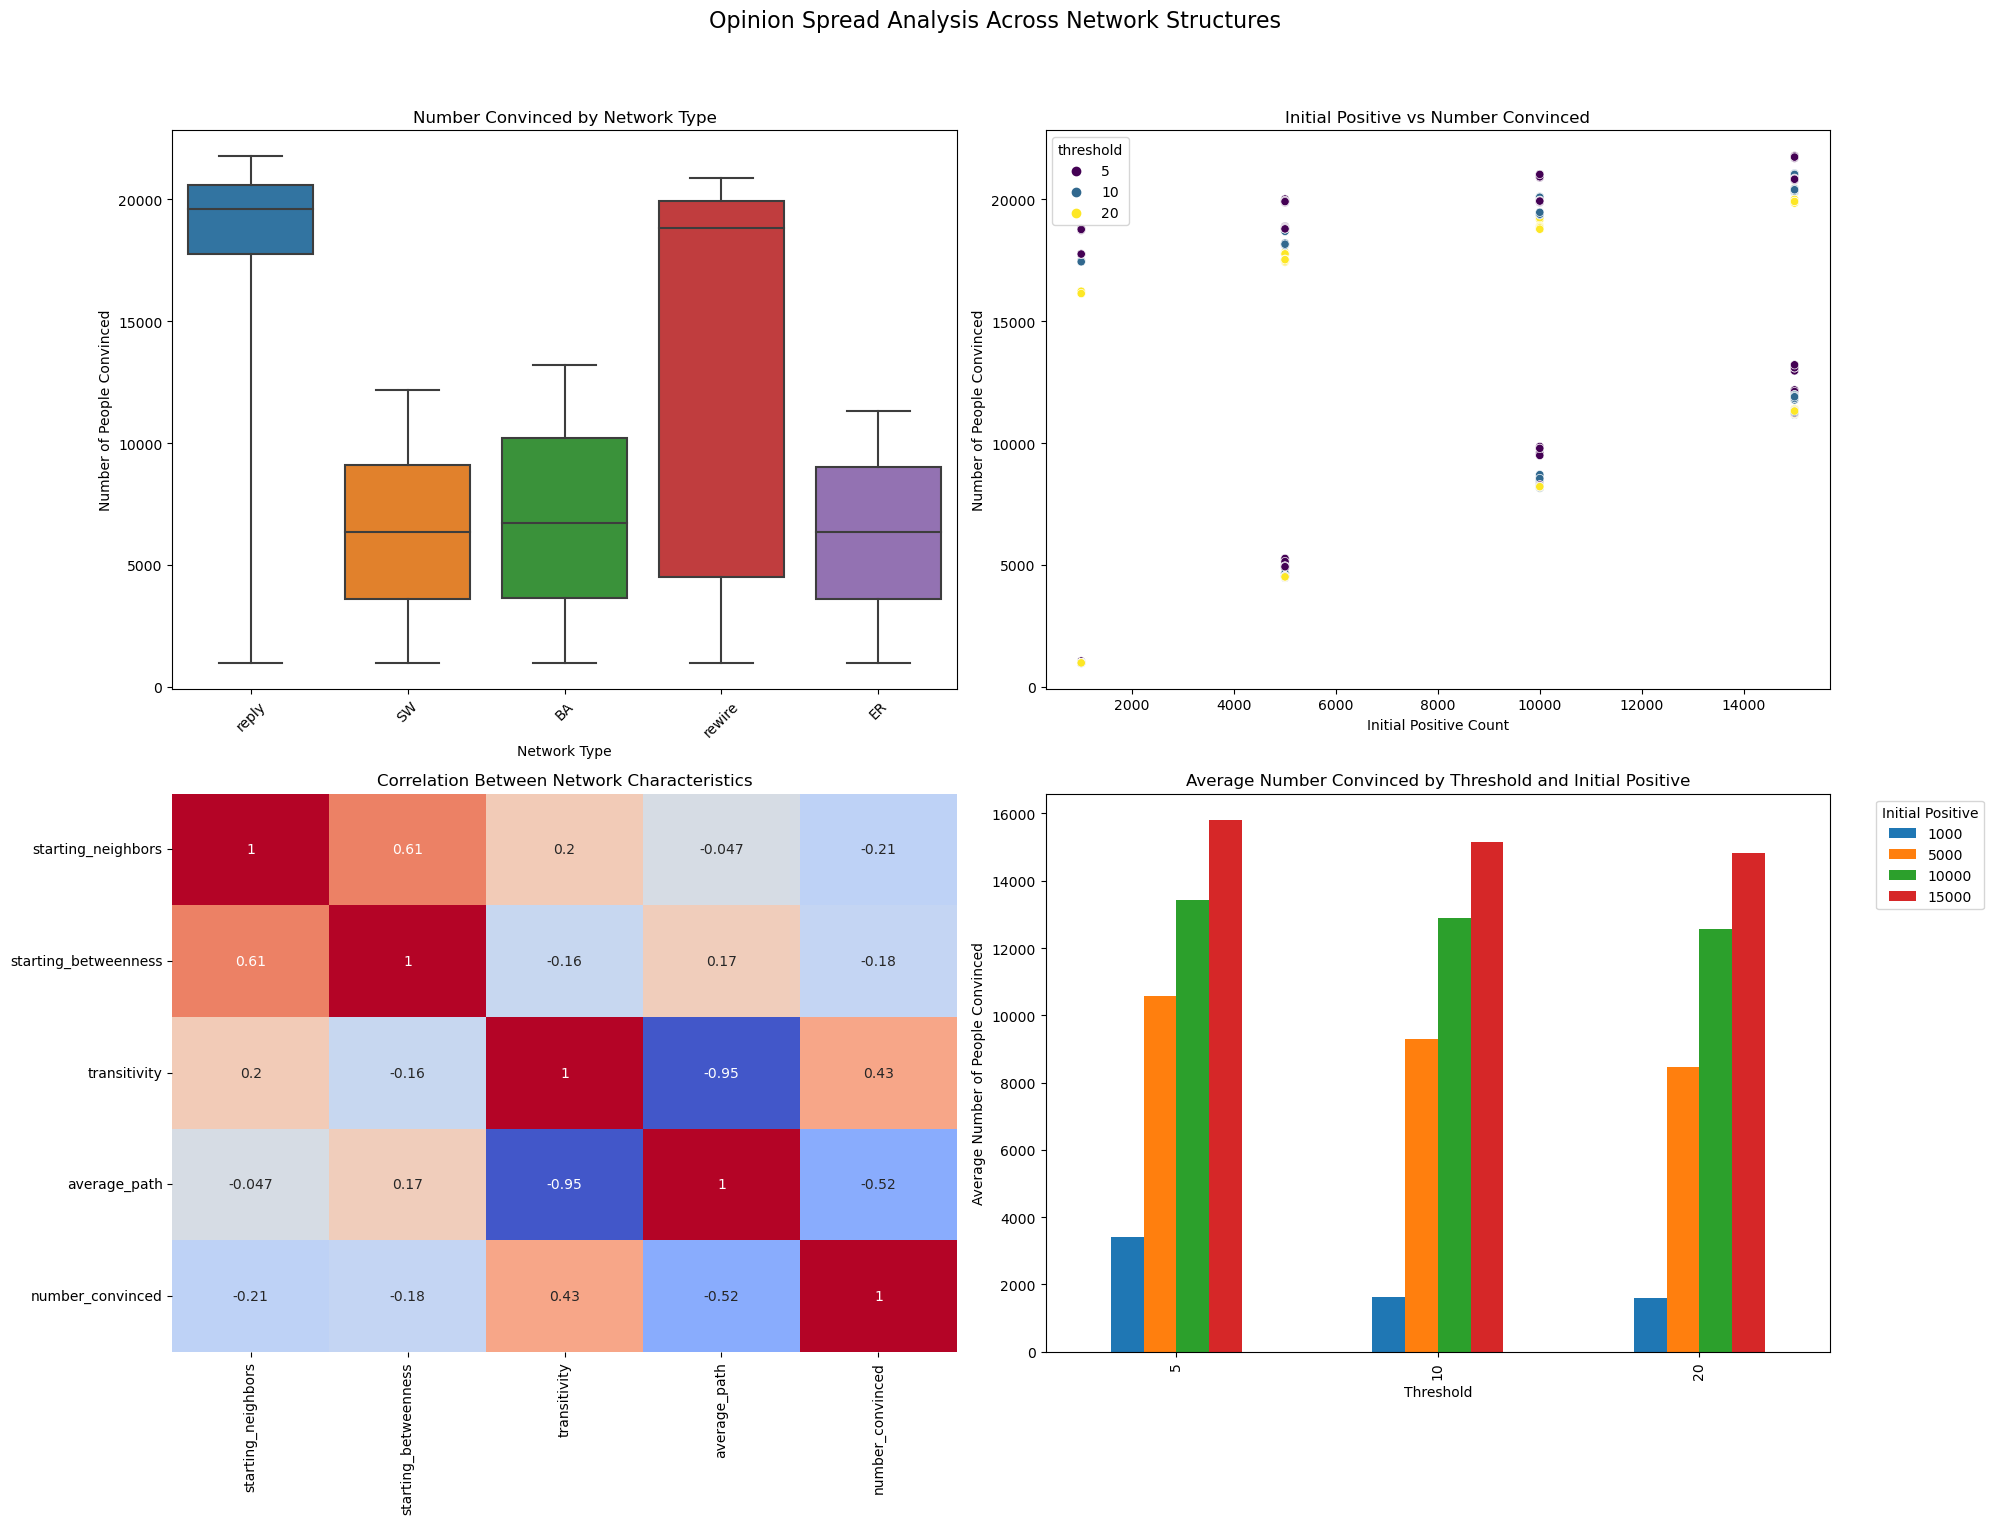

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Opinion Spread Analysis Across Network Structures', fontsize=16)

# Box plot
sns.boxplot(x='graph', y='number_convinced',
            data=opinion_df,
            ax=axs[0, 0],
            showfliers=False,
            whis=[0, 100])
axs[0, 0].set_title('Number Convinced by Network Type')
axs[0, 0].set_xlabel('Network Type')
axs[0, 0].set_ylabel('Number of People Convinced')
axs[0, 0].tick_params(axis='x', rotation=45)

# Scatter plot
scatter = sns.scatterplot(x='initial_positive', y='number_convinced', 
                           hue='threshold', data=opinion_df, 
                           palette='viridis', ax=axs[0, 1])
axs[0, 1].set_title('Initial Positive vs Number Convinced')
axs[0, 1].set_xlabel('Initial Positive Count')
axs[0, 1].set_ylabel('Number of People Convinced')

# Heatmap
correlation_cols = ['starting_neighbors', 'starting_betweenness', 
                    'transitivity', 'average_path', 'number_convinced']
correlation_matrix = opinion_df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            ax=axs[1, 0], cbar=False)
axs[1, 0].set_title('Correlation Between Network Characteristics')

# Bar plot
grouped_data = opinion_df.groupby(['threshold', 'initial_positive'])['number_convinced'].mean().reset_index()
grouped_pivot = grouped_data.pivot(index='threshold', columns='initial_positive', values='number_convinced')

grouped_pivot.plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Average Number Convinced by Threshold and Initial Positive')
axs[1, 1].set_xlabel('Threshold')
axs[1, 1].set_ylabel('Average Number of People Convinced')
axs[1, 1].legend(title='Initial Positive', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()